## High-ratio image compression: an exploration of autoencoder hyperparameter selection to minimise reconstruction error

Author: Hassan Andrabi (ID: 913838)

The following is an analysis of autoencoder network architectures to compress and accurately reconstruct high-dimensional input images. 

In [223]:
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
import json
import types
import copy
from enum import Enum
import glob
from collections import Counter

# Plotting global styles
COLORS = ["#FF412C", "#003CAB", "#9F29FF", "#C20800", "#31CAA8", "#06A6EE", "#000000"]
MARKERS = ["s", "o", "^", "P", "o", "X", "^", "v"]


## Dataset

The analysis in this note employs the MNIST database, accessible [here](http://yann.lecun.com/exdb/mnist/). The dataset contains 70,000 annotated instances of 28x28 images of handwritten digits. 60,000 instances are partitioned into a training set, and the remaining 10,000 are used for model validation.

The code in the cells below reads in the training and test dataset, and generates summary visualisations.

In [234]:
def load_mnist_data(file_path:str, nrows:int=0) -> tuple[list, list]:
	"""Reads in MNIST dataset, aquired from: 
	https://www.kaggle.com/datasets/oddrationale/mnist-in-csv.

	Args:
		file_path (str): file path to the dataset.
		nrows (int, optional): number of rows to read in. 
		Defaults to all rows.

	Returns:
		tuple[list, list]: image instances, and corresponding 
		one-hot encoded labels.
	"""
	if nrows:
		df = pd.read_csv(filepath_or_buffer=file_path, nrows=nrows)
	else: 
		df = pd.read_csv(filepath_or_buffer=file_path)
	x = ((df[df.columns[1:]]/255 * 0.99) + 0.01).to_numpy()
	y = pd.get_dummies(df["label"]).to_numpy()
	return x, y

x_train, y_train = load_mnist_data(
	file_path="data/mnist_train.csv",
)
x_test, y_test = load_mnist_data(
	file_path="data/mnist_test.csv",
)

print(f"Training set: {x_train.shape}")
print(f"Validation set: {x_test.shape}")

Training set: (60000, 784)
Validation set: (10000, 784)


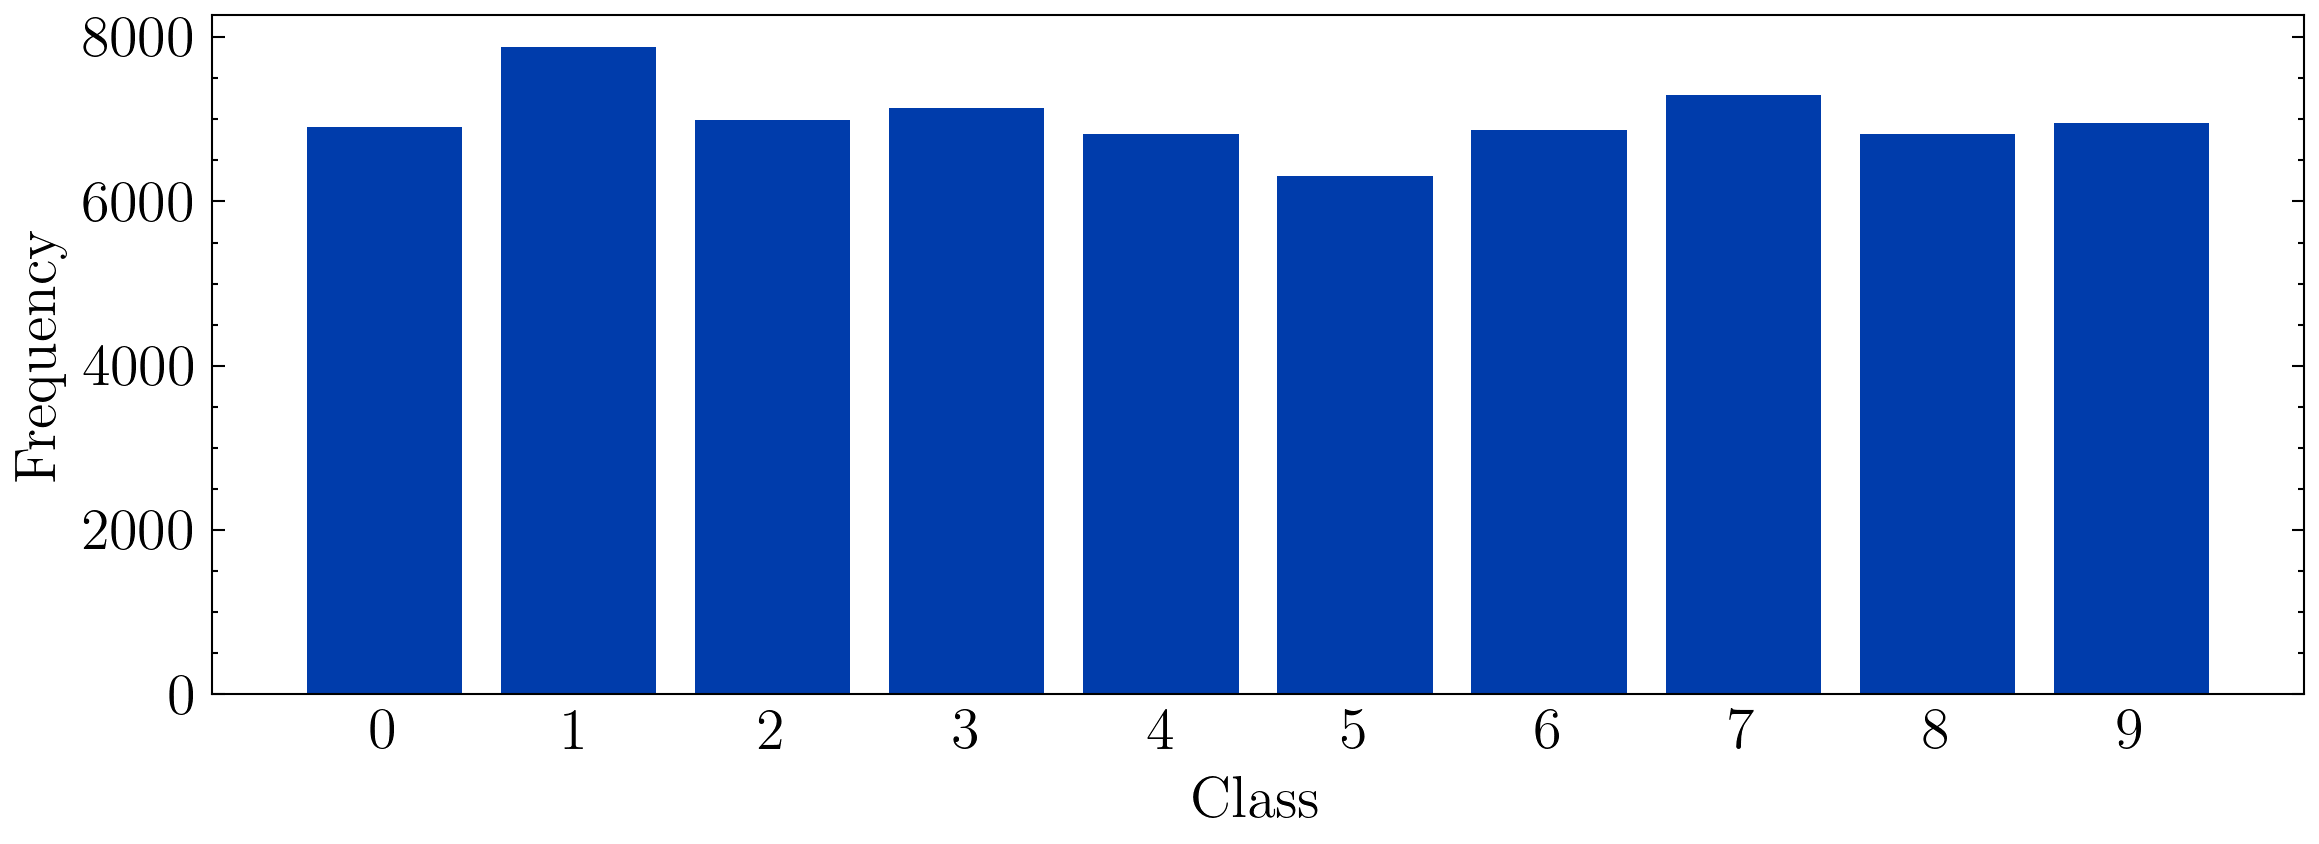

In [224]:
data = [label.index(1) for label in [*y_train.tolist(), *y_test.tolist()]]

with plt.style.context("science"):
	plt.figure(figsize=(9,3), dpi=300)
	plt.xlabel("Class", fontsize=14)
	plt.ylabel("Frequency",fontsize=14)
	plt.bar(Counter(data).keys(), Counter(data).values(), color=COLORS[1])
	plt.gca().tick_params(axis="x", which="both", length=0)
	plt.tick_params(labelsize=14)	
	plt.xticks(labels=[*range(0,10)], ticks=[*range(0,10)])
	plt.savefig(
		fname=f"../manuscript/graphics/class_distribution.pdf",
		dpi=300,
	)
	plt.show()

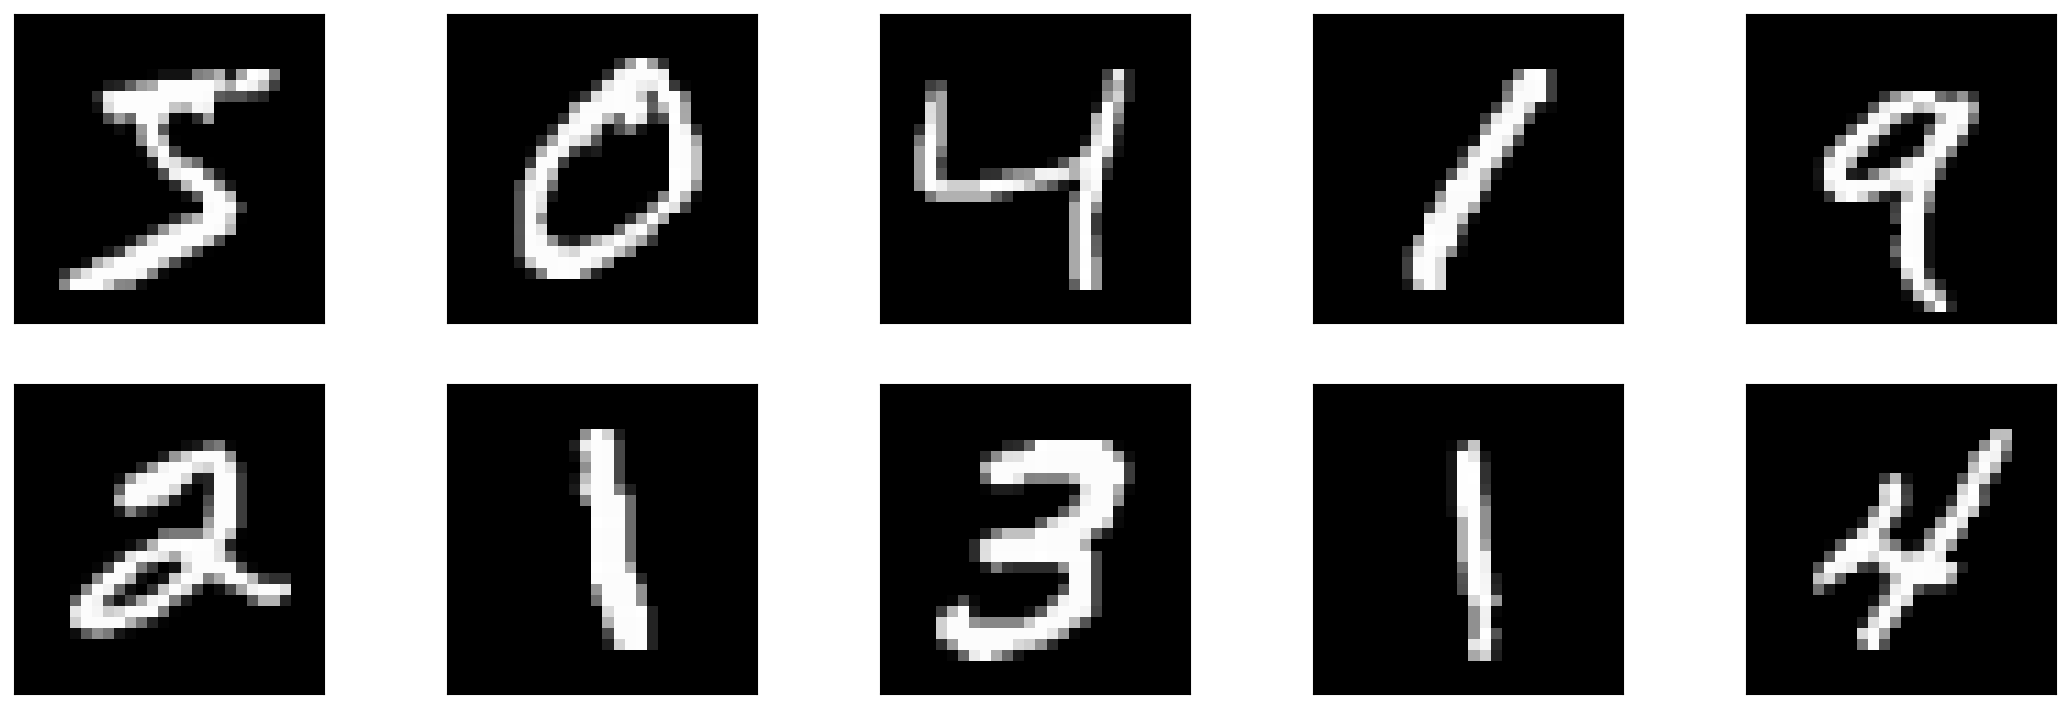

In [221]:
data = x_train[:10]

with plt.style.context("science"):
	fig, axes = plt.subplots(figsize=(9, 3), dpi=300, nrows=2, ncols=5, sharey=True, sharex=True)
	for ax, img in zip(axes.flatten(), data):
		ax.xaxis.set_visible(False)
		ax.yaxis.set_visible(False)
		im = ax.imshow(np.array(img, ndmin=2).T.reshape(28,28), cmap = plt.get_cmap("gray"))  

	plt.savefig(
		fname=f"../manuscript/graphics/instance_examples.pdf",
		dpi=300,
	)
	plt.show()

## Helpers

The code in the cells below instantiates helper classes used in the estimation of autoencoder networks. 

In [5]:
class NumpyEncoder(json.JSONEncoder):
    """Used to encode numpy arrays as native arrays 
    when saving trained autoencoder specs to .json.
    """
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [6]:
class Sigmoid:
	"""Implementation of the sigmoid function.
	"""
	def activation(self, x):
		return scipy.special.expit(x)

	def derrivative(self, x):
		return x * (1 - x)

class ActivationFunctions(Enum):
	"""Enumeration to keep track of implemented activation 
	functions for initial model validation.
	"""
	sigmoid = Sigmoid()

## Autoencoder

Autoencoders are representation-learning applications of unsupervised artificial neural networks (ANNs), that seek to learn mappings of high-dimensional data to meaningful lower-dimensional representations.
By learning fundamental representations of data, autoencoders enable fast transformation between highly compressed and uncompressed formats, and thereby enable storage and exchange of large files in compressed and computationally inexpensive formats.

The code below instantiates a generic autoencoder class, which will be used to train autoencoder instances of various architectures to compress and then reconstruct input MNIST images.

In [57]:
class AutoEncoder:
	"""Abstract implementation of an autoencoder network.
	"""

	def __init__(self, spec:dict=None, learning_rate:int=0.05):
		if spec:
			if not "input" in [layer["type"] for layer in spec["layers"]]:
				raise ValueError("Models must contain at least one input layer.")
			if not "hidden" in [layer["type"] for layer in spec["layers"]]:
				raise ValueError("Models must contain at least one hidden layer.")
			if not "output" in [layer["type"] for layer in spec["layers"]]:
				raise ValueError("Models must contain at least one output layer.")
			if 0 in [layer["nodes"] for layer in spec["layers"]]:
				raise ValueError("All layers must contain at least one node.")
			if len(list(set([layer["activation_func"] for layer in spec["layers"][1:]]).difference(ActivationFunctions._member_names_))):
				raise NotImplementedError(
					f"One or more specified activation functions are not implemented. Implemented functions include: {', '.join(ActivationFunctions._member_names_)}"
				)

			self.spec = spec
			self.spec["loss"] = []
			self.learning_rate = learning_rate
			
			for i, layer in enumerate(spec["layers"]):
				if layer["type"] != "output":
					next_layer = spec["layers"][i+1]
					self.spec["layers"][i]["weights"] = np.random.normal(
						loc=0.0, 
						scale=pow(next_layer["nodes"], -0.5), 
						size=(next_layer["nodes"], layer["nodes"])
					)
					if self.spec.get("bias", False):
						self.spec["layers"][i]["bias"] = np.random.normal(
							loc=0.0, 
							scale=pow(next_layer["nodes"], -0.5), 
							size=(next_layer["nodes"],1)
						)
			self.model_summary()
	
	def train(self, train_instances:list, test_instances:list, epochs:int=1) -> None:
		"""Trains model using input instances and labels.

		Args:
			train_instances (list): tensor of input instances.
			test_instances (list): tensor of test instances.
			epochs (int, optional): number of epochs for which to
			train the model. Defaults to 1.
		"""
		print("\n".join([
			"========================================",
			"Training Model",
			"========================================",
		]))
		for epoch in range(epochs):
			print(f"Epoch: {epoch}/{epochs}")
			for i, instance in enumerate(train_instances):
				if (((i+1)/len(train_instances)) * 100) % 25 == 0:
					print(f"Progress: {((i+1)/len(train_instances)) * 100}%")
				
				activations = self.forward_pass(instance)
				self.backpropogate(instance, activations)
			
			self.spec["loss"].append(
				self.evaluate(test_instances)
			)

	def forward_pass(self, instance:list) -> list:
		"""Conducts a forward pass through the model,
		generating activations for hidden and output
		layer(s).

		Args:
			instance (list): instance for which to conduct forward 
			pass.

		Returns:
			list: list of dictionaries containing activations
			at each layer.
		"""
		activations = copy.deepcopy(self.spec["layers"])
		for i, layer in enumerate(activations):
			if layer["type"] == "input":
				activations[i]["activations"] = np.array(instance, ndmin=2)
			else:
				activation_func = ActivationFunctions[layer["activation_func"]].value
				bias = activations[i-1].get("bias", 0)
				inputs = np.dot(activations[i-1]["weights"], activations[i-1]["activations"].T) - bias
				activations[i]["activations"] = activation_func.activation(inputs).T
		return activations

	def backpropogate(self, instance:list, activations:list) -> None:
		"""Adjusts model weights through backpropogation.
		Implemented backpropogation assumes sigmoid activation
		functions.

		Args:
			instance (list): instance for which to backpropogate.
			activations (list): list of dictionaries containing activations
			at each layer. Output by self.forward_pass.
		"""
		for i, layer in reversed(list(enumerate(activations))[1:]):
			if layer["type"] == "output":
				activations[i]["errors"] = np.array(instance, ndmin=2).T - layer["activations"].T
			else:
				activations[i]["errors"] = np.dot(layer["weights"].T, activations[i+1]["errors"])

			activation_func = ActivationFunctions[layer["activation_func"]].value
			
			self.spec["layers"][i-1]["weights"] += self.learning_rate * (
				np.dot(
					activations[i]["errors"] * activation_func.derrivative(activations[i]["activations"].T),
					activations[i-1]["activations"]
				)
			)
			if self.spec["bias"]:
				self.spec["layers"][i-1]["bias"] += self.learning_rate * (
					activations[i]["errors"] * activation_func.derrivative(activations[i]["activations"].T) * -1
				)

	def query(self, instance:list) -> None:
		"""Queries the trained model to encode and reconstruct
		an input instance.

		Args:
			instance (list): instance to resconstruct.
		"""
		activations = self.forward_pass(instance)
		reconstructed_instance = activations[-1]["activations"].T

		fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=2, sharey=True, sharex=True)
		for ax, img in zip(axes.flatten(), [instance, reconstructed_instance]):
			ax.xaxis.set_visible(False)
			ax.yaxis.set_visible(False)
			im = ax.imshow(np.array(img, ndmin=2).T.reshape(28,28), cmap = plt.get_cmap("gray"))  
	
		
	def evaluate(self, instances:list) -> float:
		"""Encodes and decodes a set of instances and calculates reconstruction
		errors as mean-squared error of pixel value deviations.

		Args:
			instance (list): instance for which to backpropogate.

		Returns:
			float: average mean-squared error.
		"""
		errors = []
		for instance in instances:
			activations = self.forward_pass(instance)
			prediction = activations[-1]["activations"]
			errors.append((np.square(instance - prediction)).mean(axis=0))

		avg_mse = np.asarray(errors).mean()
		print("Average MSE: {}".format(avg_mse))
		return avg_mse

	def save(self, dir_path:str) -> None:
		"""Writes trained model spec to json.
		
		Args:
			dir_path (str): path to directory in which to save model.
		"""
		with open(f"{dir_path}{self.spec['name']}.json", "w") as f:
			json.dump(self.spec, f, cls=NumpyEncoder)
			print(f"Model saved to {dir_path}{self.spec['name']}.json.")

	def load(self, path_to_spec:str, print_summary:bool=True) -> dict:
		"""Loads in a trained model from json specification file.

		Args:
			path_to_spec (str): path to json specification file.
			print_summary (bool, optional): whether or not to print
			summary of model when it is loaded. Defaults to True.

		Returns:
			dict: trained model specification.
		"""
		with open(path_to_spec) as f:
			spec = json.load(f)
			for i, layer in enumerate(spec["layers"][:-1]):
				spec["layers"][i]["weights"] = np.asarray(spec["layers"][i]["weights"])
			self.spec = spec
			if print_summary:
				self.model_summary()

	def model_summary(self):
		print("\n".join([
			"========================================",
			"Model summary: {}".format(self.spec["name"]),
			"========================================",
			*["{} layer:	{} nodes".format(layer["type"].title(), layer["nodes"]) for layer in self.spec["layers"]],
			"========================================",
		]))

## Debugging

Use the code in the cell below to initiate single instances of the `Autoencoder()` class for debugging.

In [58]:
spec = {
	"name": "hl_2_bias",
	"layers": [
		{ "type": "input", "nodes": 784 },
		{ "type": "hidden", "nodes": 2, "activation_func": "sigmoid" },
		{ "type": "output", "nodes": 784, "activation_func": "sigmoid" },
	],
	"bias": True,
}

model = AutoEncoder(spec, 0.01)
model.train(
	train_instances=x_train, 
	test_instances=x_test, 
	epochs=3
)
model.save(dir_path="./models/scratch/")

Model summary: hl_2_bias
Input layer:	784 nodes
Hidden layer:	2 nodes
Output layer:	784 nodes
Training Model
Epoch: 0/3
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
hl_2_bias average MSE: 0.06519829514010576
Epoch: 1/3
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
hl_2_bias average MSE: 0.06516272561468434
Epoch: 2/3
Progress: 25.0%
Progress: 50.0%
Progress: 75.0%
Progress: 100.0%
hl_2_bias average MSE: 0.06515441343977668
Model saved to ./models/scratch/hl_2_bias.json.


## Model estimation

The code in the cell below creates instances of the `Autoencoder()` class to train a range of autoencoder networks that are covered in the accompanying paper. 

A generic autoencoder architecture is implemented (see `base_spec`), consisting of an input layer with 784 nodes (corresponding to the 28x28 MNIST image dimensions); a single fully-connected hidden layer with a variable number of nodes; and an output layer with 784 nodes. Each architecture is modelled twice: once with the inclusion of a constant bias unit, and once with bias set to zero.
A Sigmoid activation function is used to calculate activations in hidden and output nodes. 
To assess the role of compression ratios in reconstruction performance, the number of nodes in the hidden layer is varied across seven values: 2, 4, 8, 16, 32, 64, and 128. 

In total, fourteen autoencoder networks are trained.
* 2 hidden notes (CR: 392)
* 2 hidden notes (CR: 392) with bias
* 4 hidden notes (CR: 196)
* 4 hidden notes (CR: 196) with bias
* 8 hidden notes (CR: 98)
* 8 hidden notes (CR: 98) with bias
* 14 hidden notes (CR: 56)
* 14 hidden notes (CR: 56) with bias
* 28 hidden notes (CR: 28)
* 28 hidden notes (CR: 28) with bias
* 56 hidden notes (CR: 14)
* 56 hidden notes (CR: 14) with bias
* 112 hidden notes (CR: 7)
* 112 hidden notes (CR: 7) with bias


In [ ]:
base_spec = {
	"name": None,
	"layers": [
		{ "type": "input", "nodes": 784 },
		{ "type": "hidden", "nodes": None, "activation_func": "sigmoid" },
		{ "type": "output", "nodes": 784, "activation_func": "sigmoid" },
	],
	"bias": False,
}

for hl in [2, 4, 8, 14, 28, 56, 112]:
	for bias in [True, False]:
		spec = base_spec
		spec["bias"] = bias
		if bias:
			spec["name"] = f"hl_{hl}_bias"
		else:
			spec["name"] = f"hl_{hl}"
		spec["layers"][1]["nodes"] = hl
		model = AutoEncoder(spec, 0.05)
		model.train(
			train_instances=x_train, 
			test_instances=x_test, 
			epochs=50
		)
		model.save(dir_path="./models/")


## Visualisations

The remainder of the code in this notebook generates visualisations of the training, validation, and image-reconstruction performance of estimated autoencoder networks.

hl_16


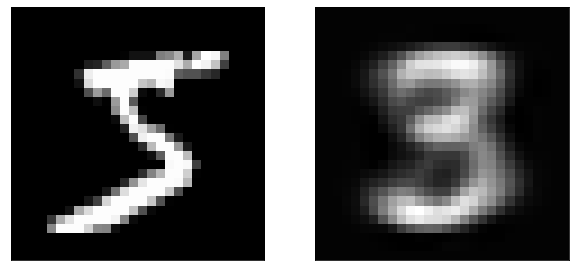

hl_16_bias


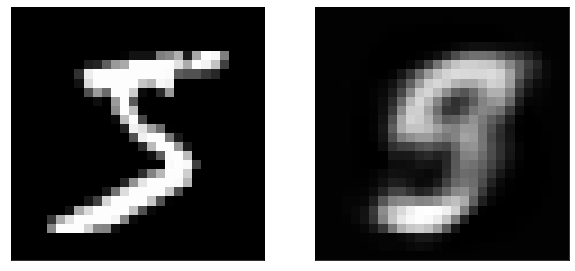

In [230]:
model1 = AutoEncoder()
model1.load(
	path_to_spec="./models/hl_16.json",
	print_summary=False,
)
model2 = AutoEncoder()
model2.load(
	path_to_spec="./models/hl_16_bias.json",
	print_summary=False
)
for i in range(0, 1):
	print(model1.spec["name"])
	model1.query(instance=x_train[i])
	plt.show()
	print(model2.spec["name"])
	model2.query(instance=x_train[i])
	plt.show()

## Reconstruction mean-squared error throughout training phase, disaggregated by network architecture

Mean-squared error (MSE) of autoencoder networks across validation partition of MNIST dataset. MSE was calculated through forward propagation of MNIST validation instances (N=10,000) using trained weights at each discrete training time step. Learning rate for each model was set at 0.01.

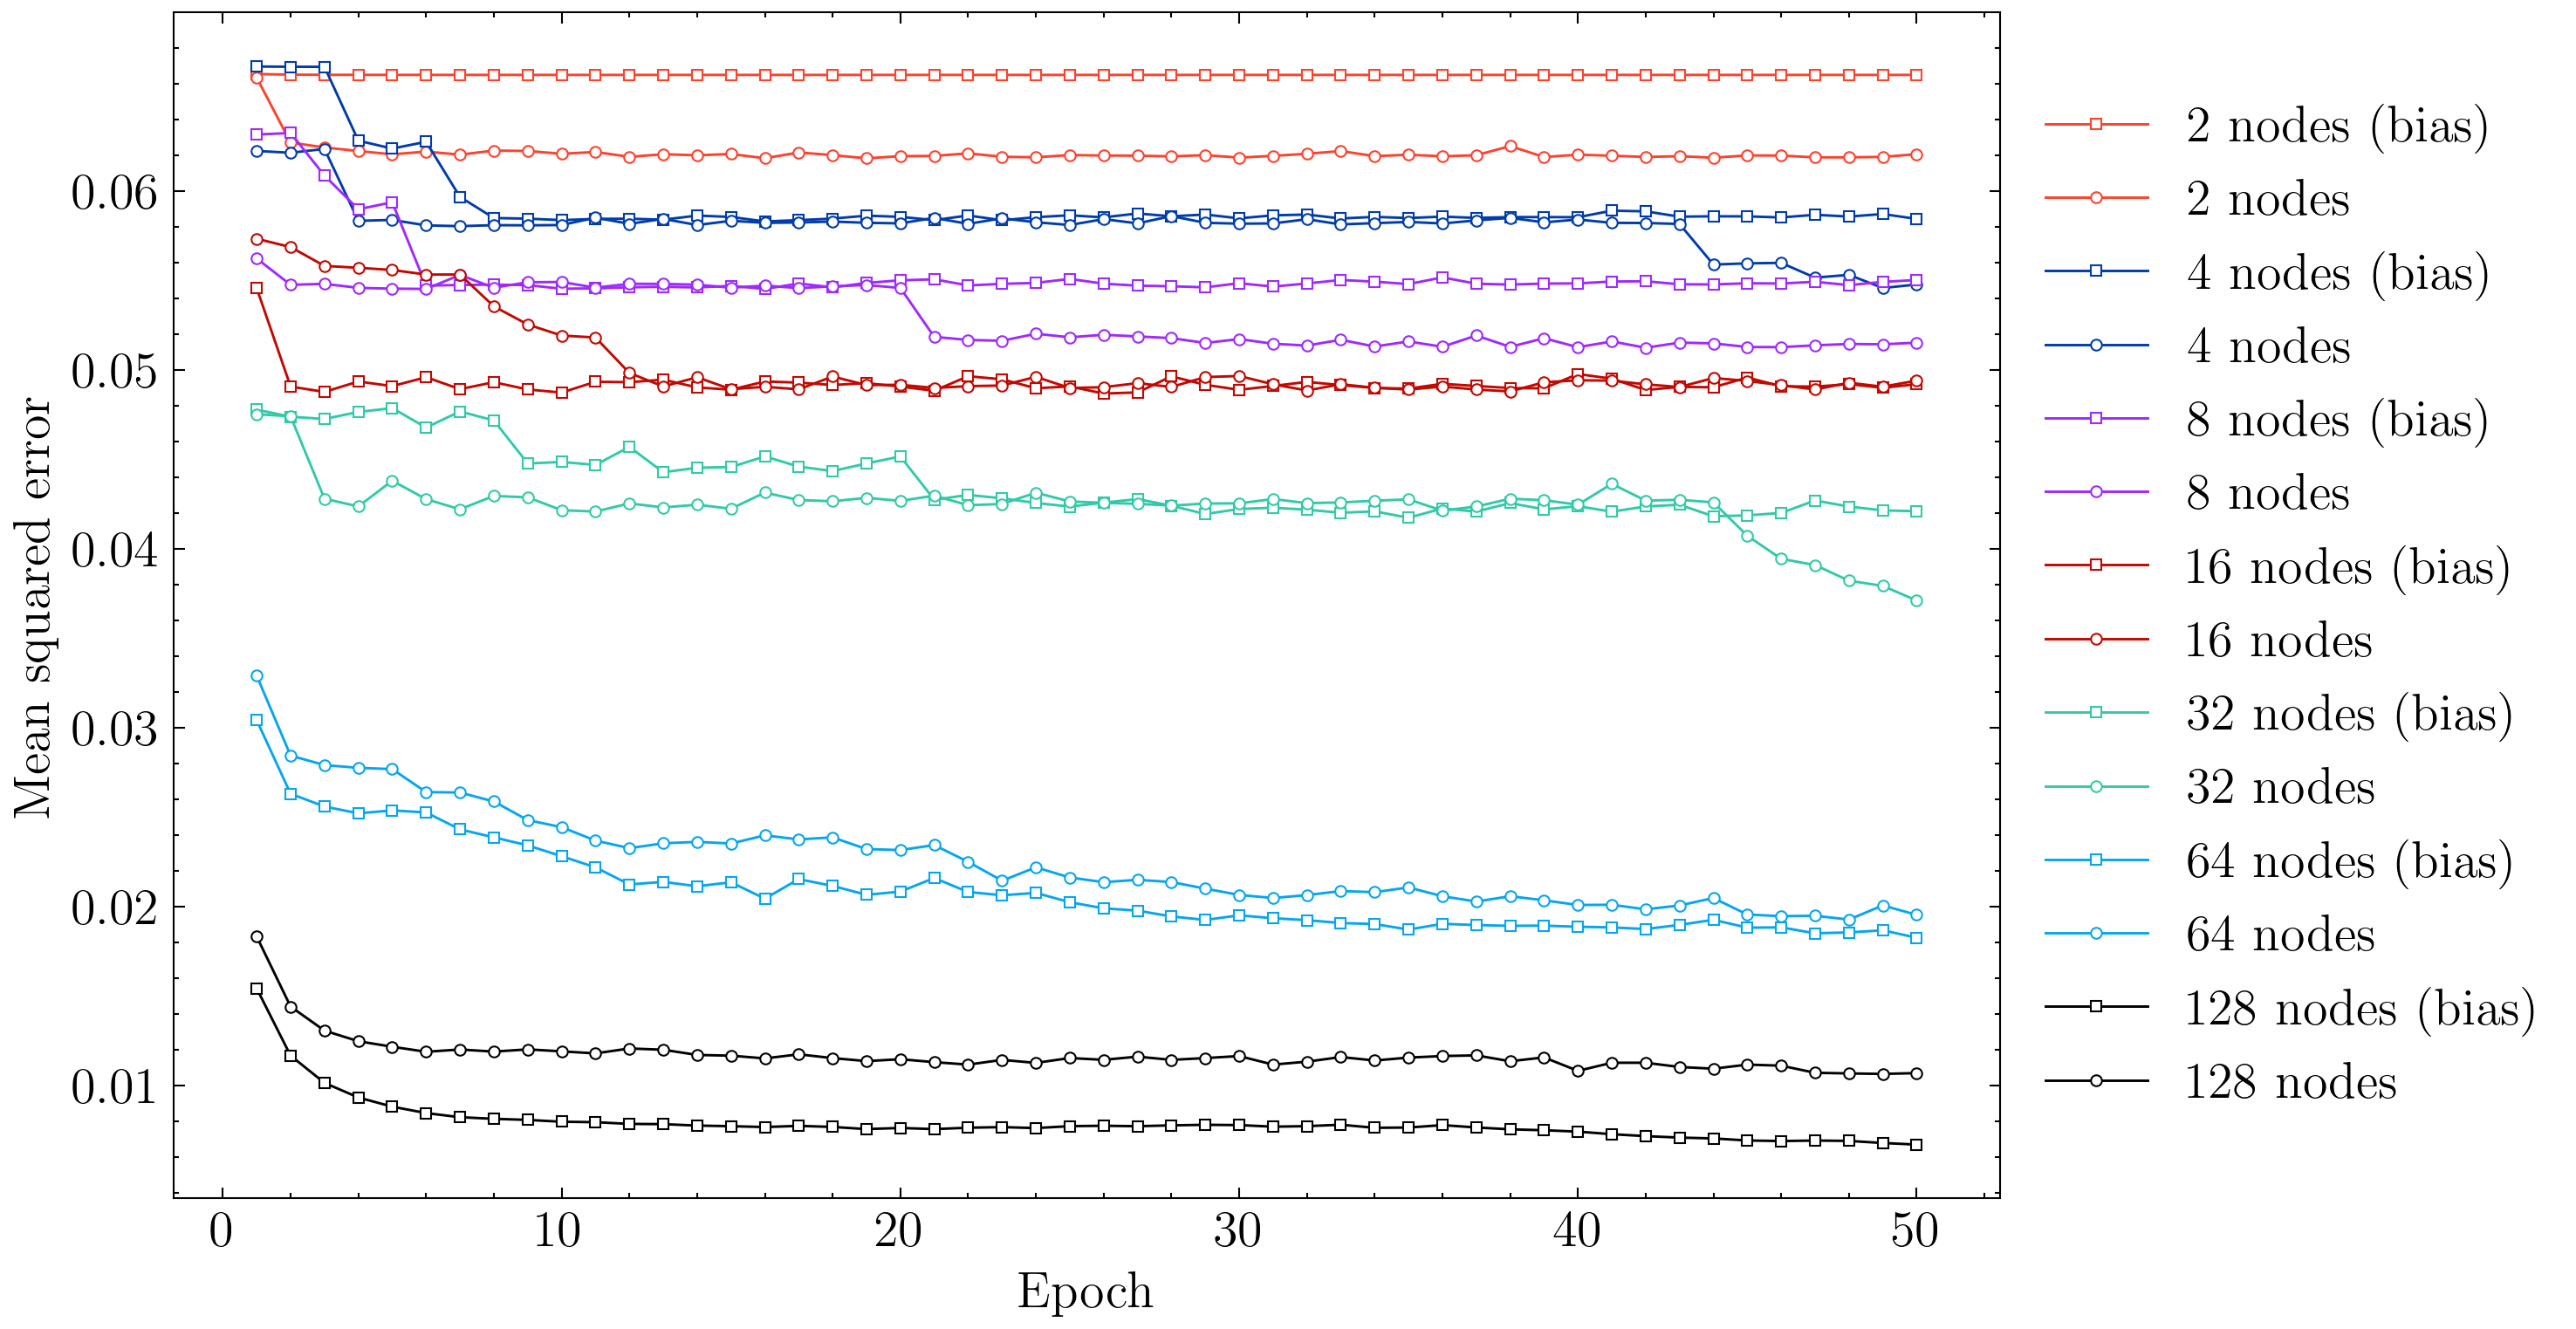

In [163]:
with plt.style.context("science"):
	plt.figure(figsize=(9,6), dpi=300)
	for hl_i, hl in enumerate([2, 4, 8, 16, 32, 64, 128]):
		for bias_i, bias in enumerate([True, False]):
			if bias:
				model_name = f"hl_{hl}_bias"
				plot_label = f"{hl} nodes (bias)"
			else:
				model_name = f"hl_{hl}"
				plot_label = f"{hl} nodes"
			model = AutoEncoder()
			model.load(
				path_to_spec=f"./models/{model_name}.json",
				print_summary=False,
			)
			mse = model.spec["loss"]
			plt.plot(
				[*range(1, len(mse)+1)], 
				mse,
				color=COLORS[hl_i],
				marker=MARKERS[bias_i],
				markerfacecolor="#ffffff",
				markersize=3,
				linewidth=0.7,
				markeredgewidth=0.5,
				label=plot_label
			)

	plt.tick_params(labelsize=14)	
	plt.xlabel("Epoch", fontsize=14)
	plt.ylabel("Mean squared error",fontsize=14)
	plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fontsize=14)
	plt.savefig(
		fname=f"../manuscript/graphics/model_loss.pdf",
		dpi=300,
	)
	plt.show()

## Reconstructed instances disaggregated by compression ratio (no bias units)

Reconstructed images are generated by encoding and decoding a stimulus image using a trained autoencoder networks with varying hidden layers, and bias set to zero. Columns separate reconstructed images by compression ratio (CR). Rows separate reconstructed images by the input stimulus (uncompressed) image. The first entry in each row is the stimulus image used to generate the following reconstructions.

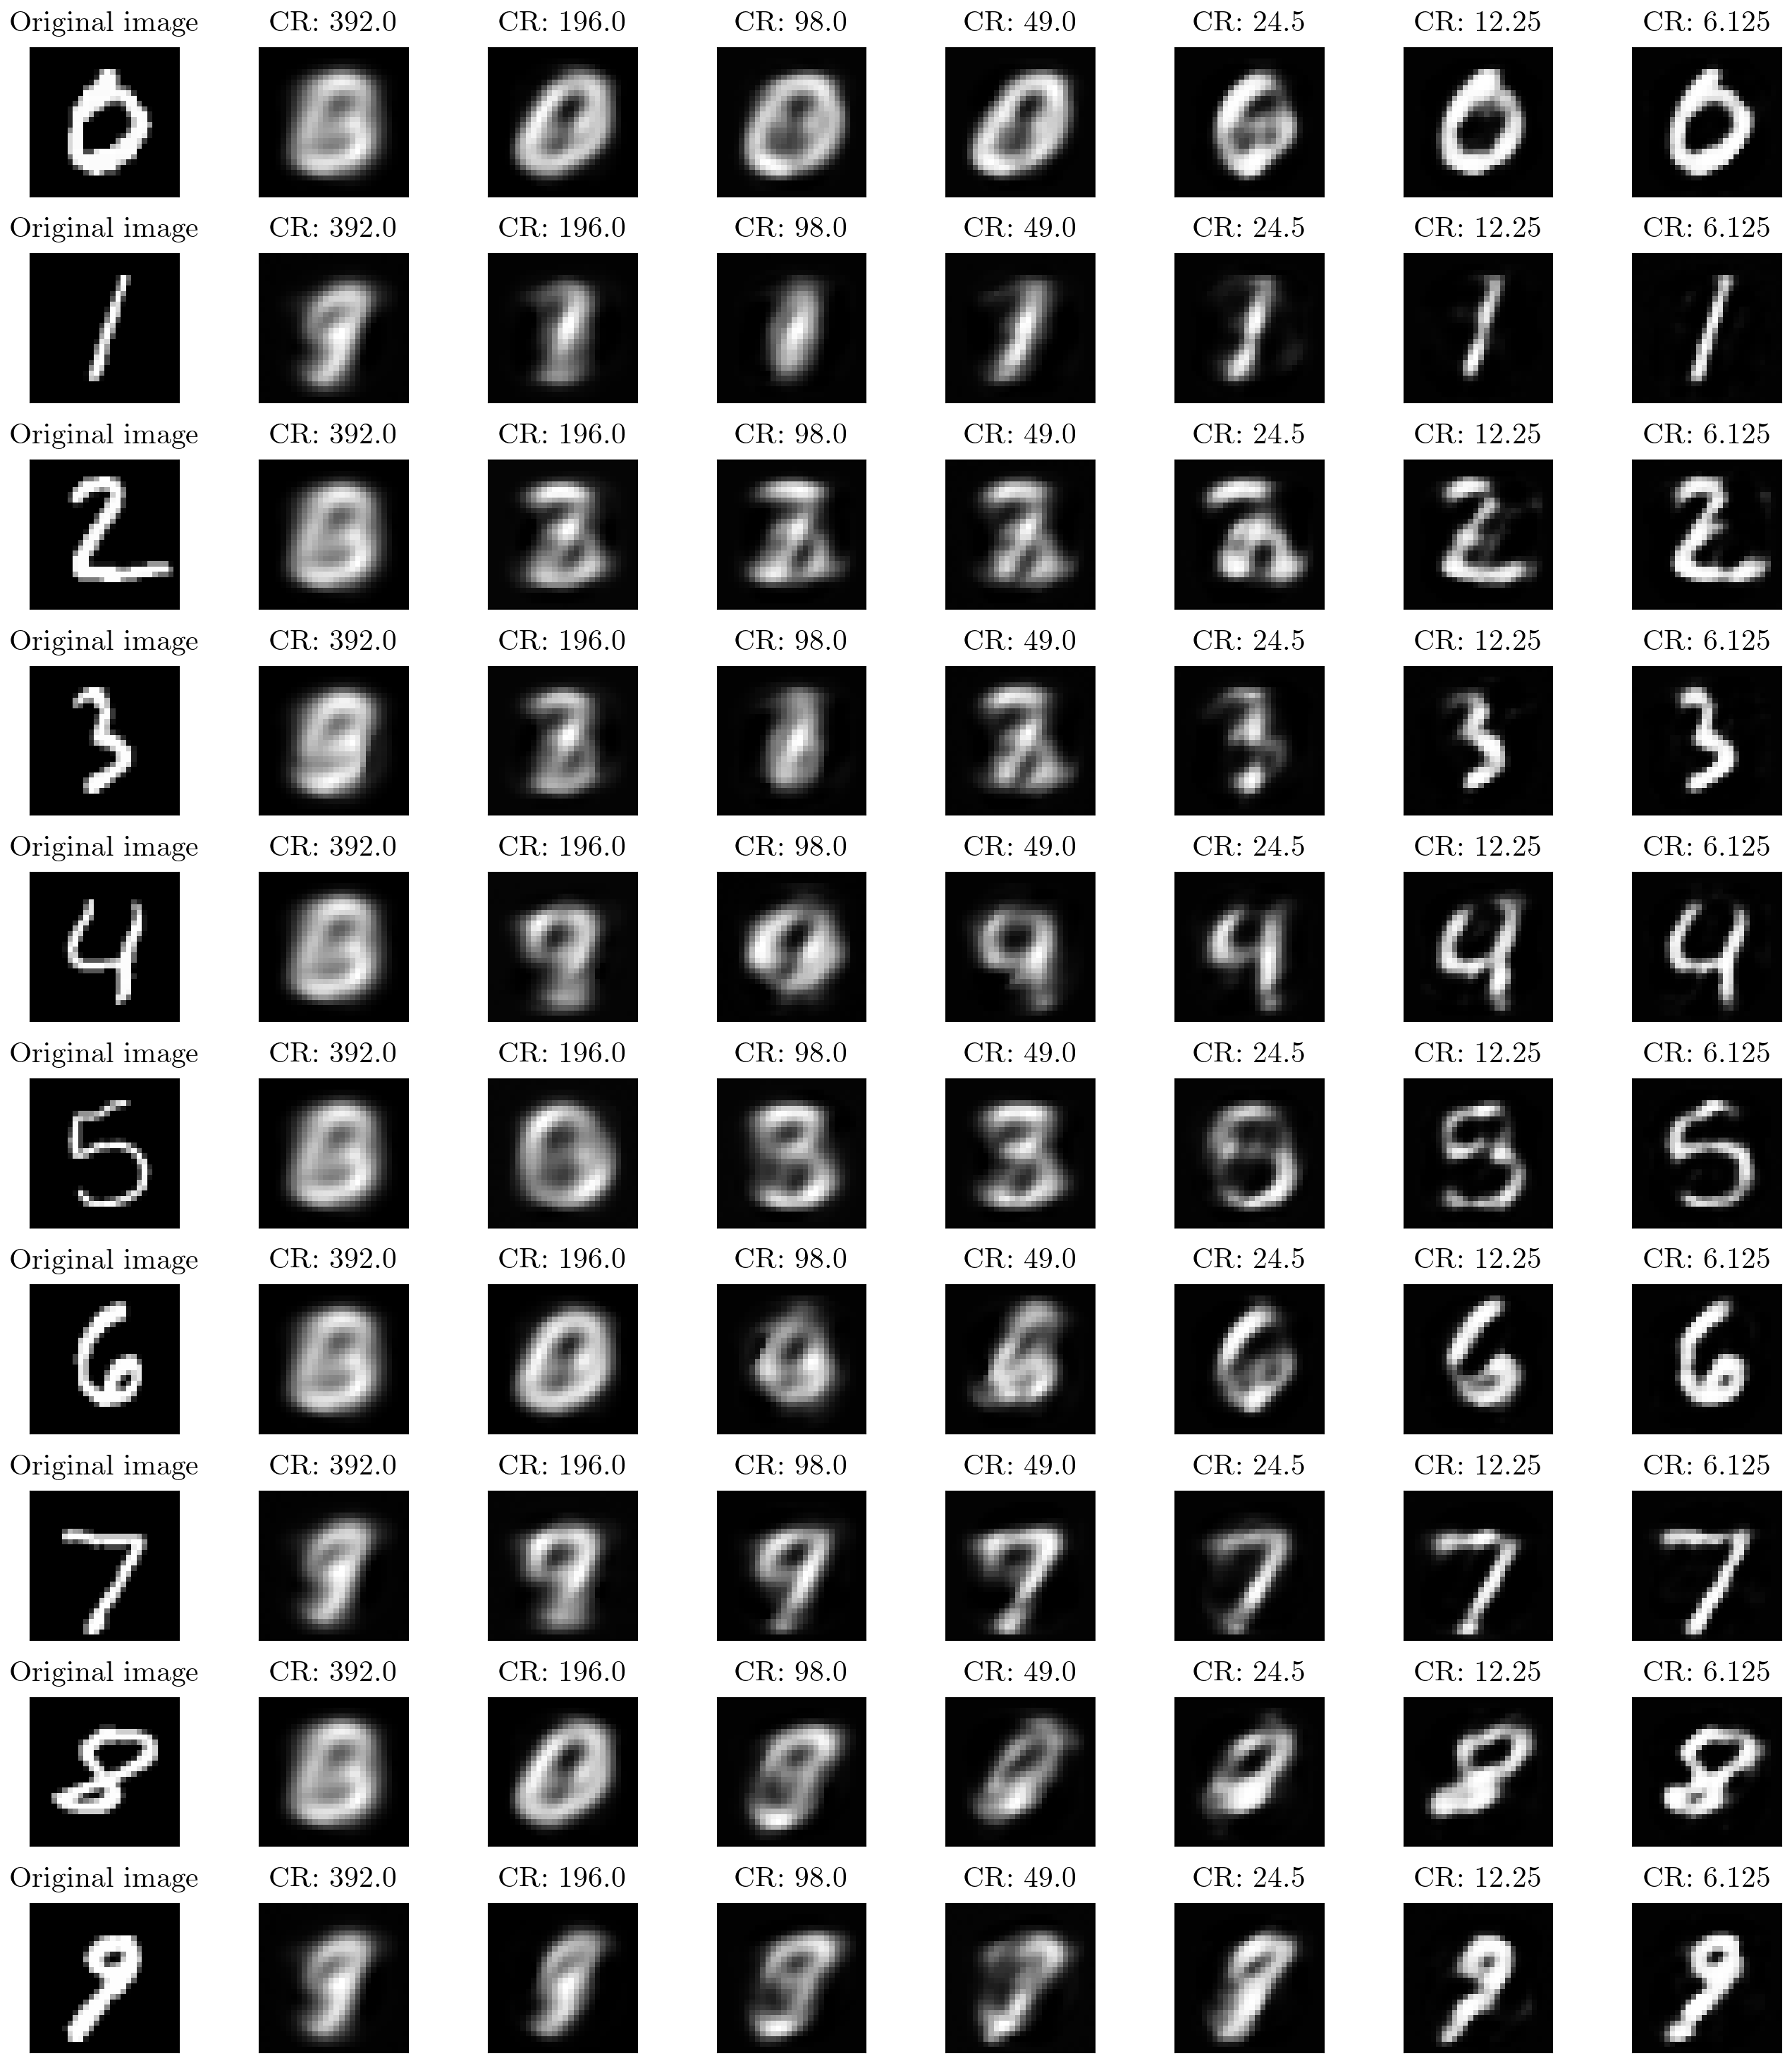

In [204]:
data = [
	x_test[3],
	x_test[2],
	x_test[1],
	x_test[44],
	x_test[4],
	x_test[53],
	x_test[81],
	x_test[0],
	x_test[61],
	x_test[73],
]

with plt.style.context("science"):
	fig, axes = plt.subplots(figsize=(9, 10), dpi=300, nrows=10, ncols=8, sharey=True, sharex=True)
	fig.tight_layout()
	for i, img in enumerate(data):
		for j, hl in enumerate([None, 2, 4, 8, 16, 32, 64, 128]):
			if j == 0: 
				axes[i][j].xaxis.set_visible(False)
				axes[i][j].yaxis.set_visible(False)
				axes[i][j].set_title("Original image", fontsize=10)
				im = axes[i][j].imshow(np.array(img, ndmin=2).T.reshape(28,28), cmap = plt.get_cmap("gray")) 
			else: 
				model_name = f"hl_{hl}"
				plot_label = f"CR: {784/hl}"
				model = AutoEncoder()
				model.load(
					path_to_spec=f"./models/{model_name}.json",
					print_summary=False,
				)
				activations = model.forward_pass(img)
				reconstructed_instance = activations[-1]["activations"].T
				axes[i][j].xaxis.set_visible(False)
				axes[i][j].yaxis.set_visible(False)
				axes[i][j].set_title(plot_label, fontsize=10)
				im = axes[i][j].imshow(np.array(reconstructed_instance, ndmin=2).T.reshape(28,28), cmap = plt.get_cmap("gray")) 
		
	plt.savefig(
		fname=f"../manuscript/graphics/decoded_instances.pdf",
		dpi=300,
	)
	plt.show()

## Reconstructed instances disaggregated by compression ratio (with bias units)

Reconstructed images are generated by encoding and decoding a stimulus image using a trained autoencoder networks with varying hidden layers, and bias units included. Columns separate reconstructed images by compression ratio (CR). Rows separate reconstructed images by the input stimulus (uncompressed) image. The first entry in each row is the stimulus image used to generate the following reconstructions.

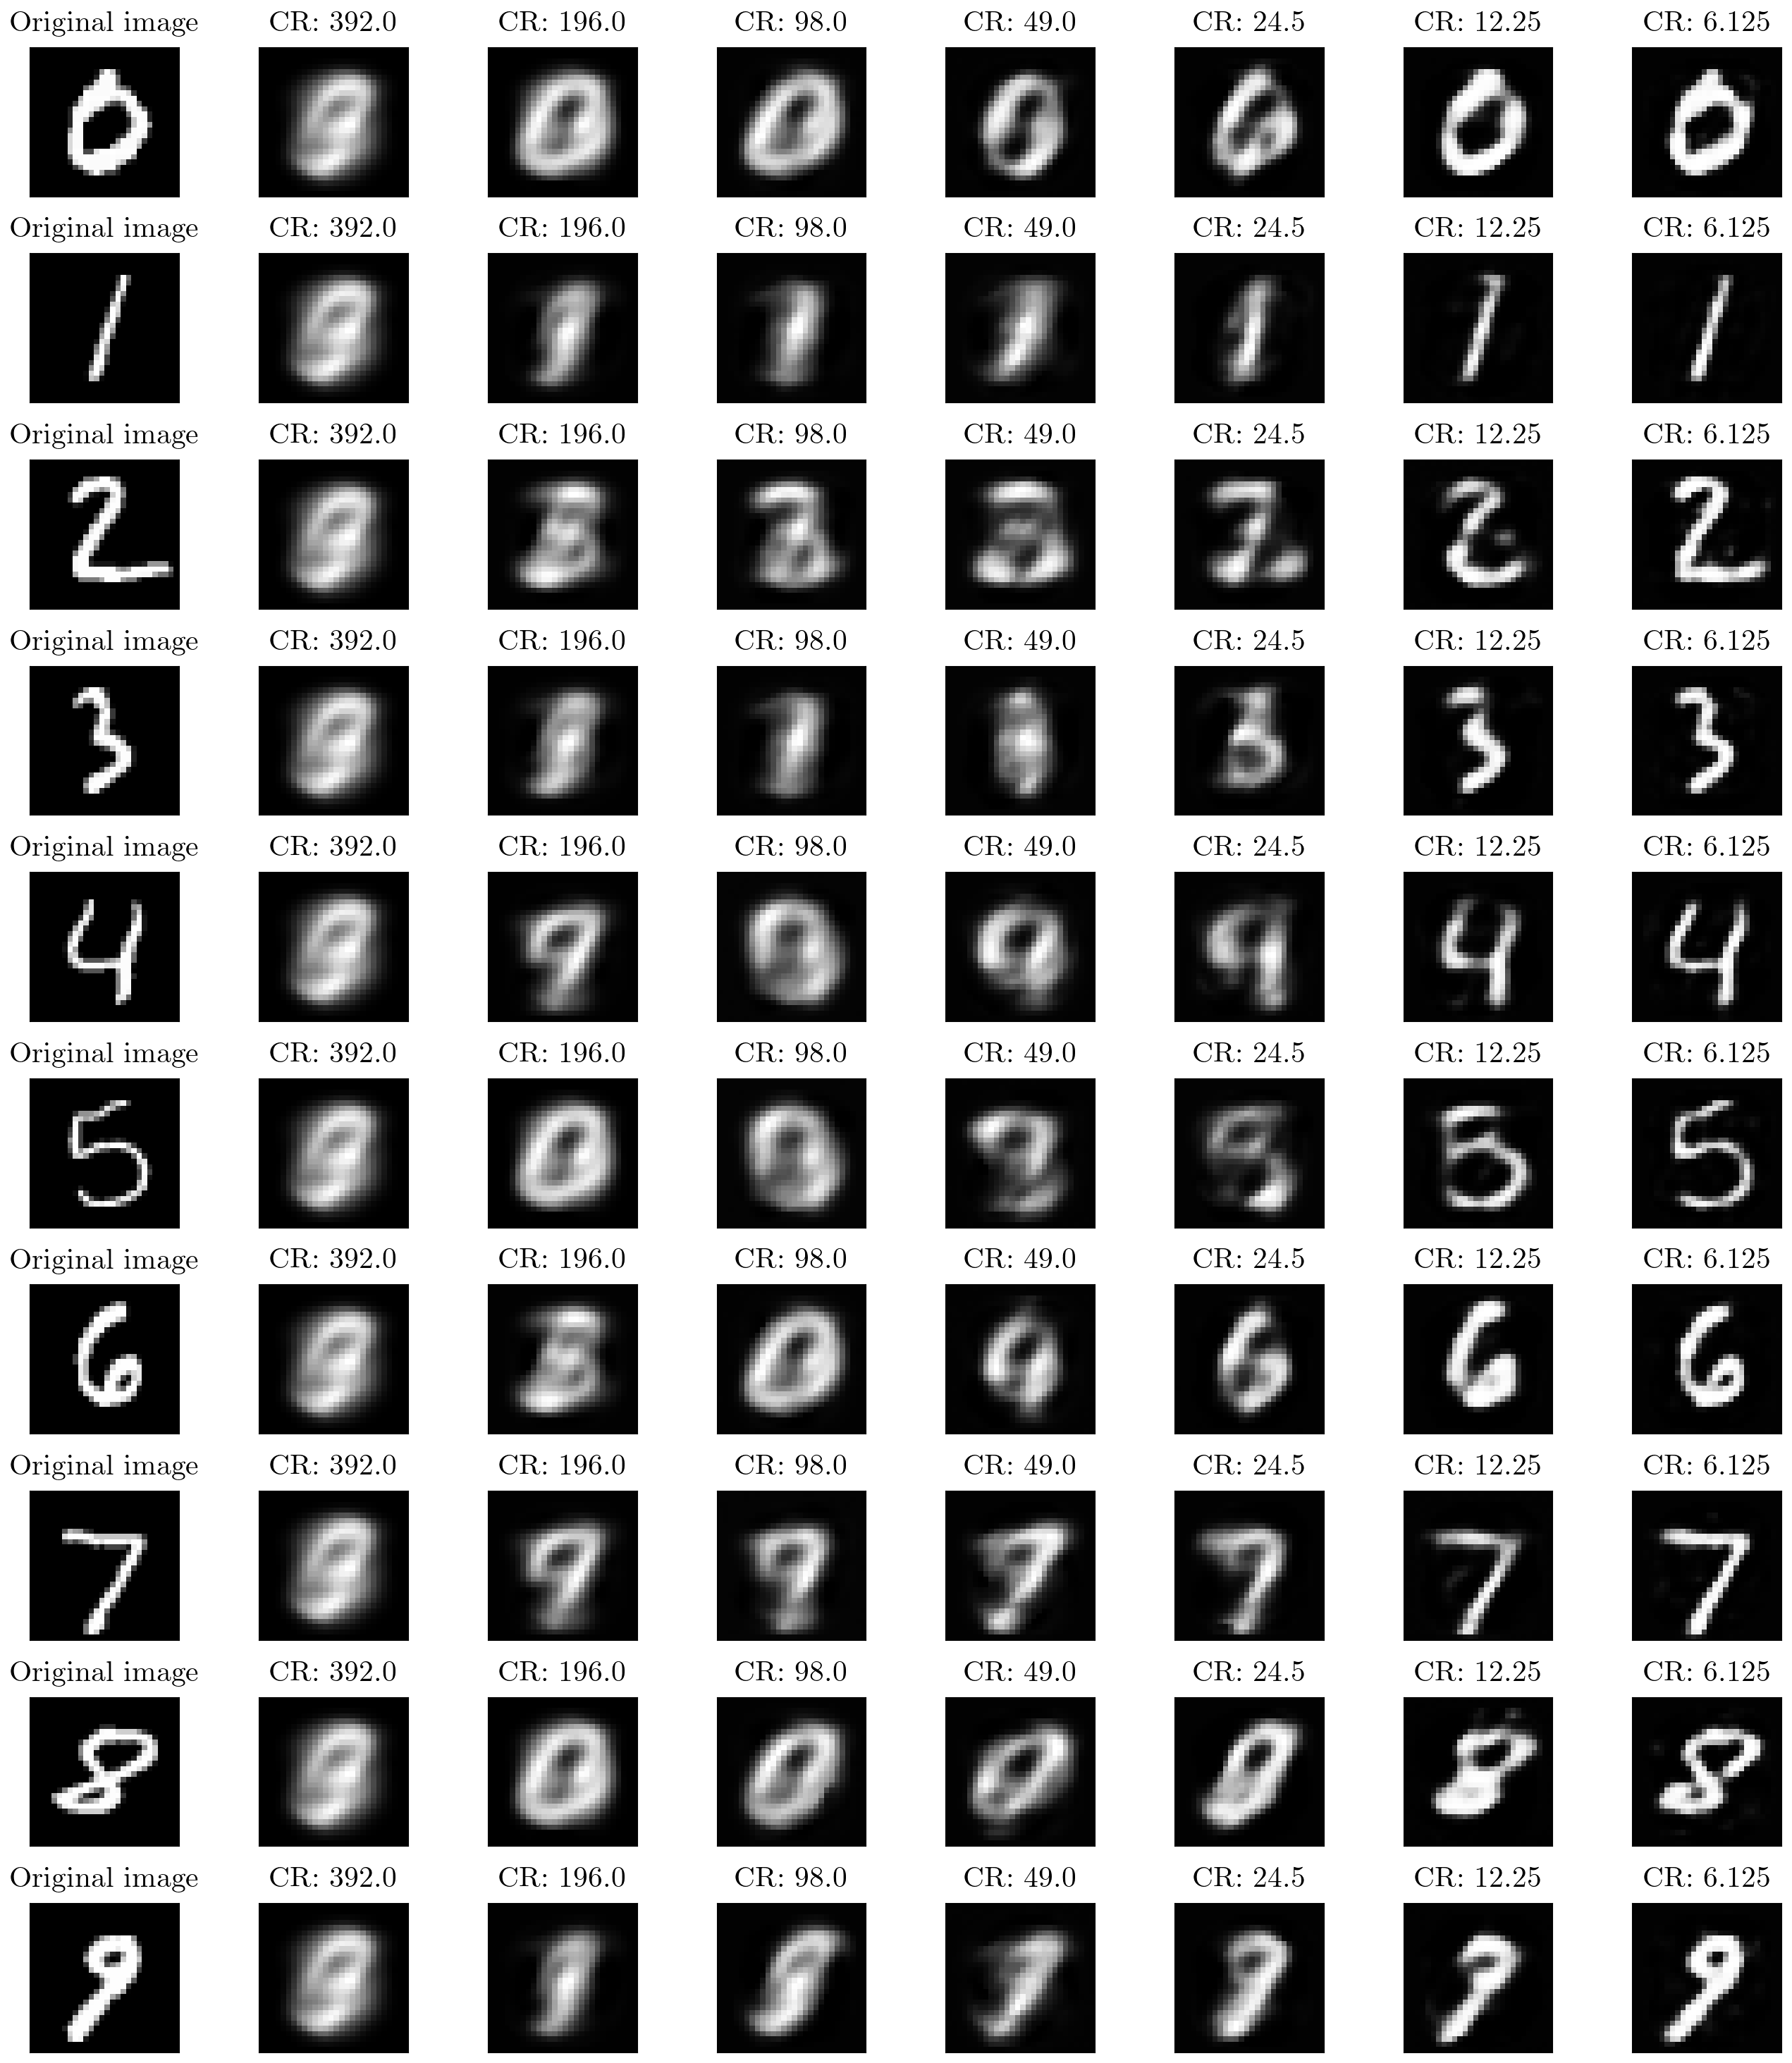

In [205]:
data = [
	x_test[3],
	x_test[2],
	x_test[1],
	x_test[44],
	x_test[4],
	x_test[53],
	x_test[81],
	x_test[0],
	x_test[61],
	x_test[73],
]

with plt.style.context("science"):
	fig, axes = plt.subplots(figsize=(9, 10), dpi=300, nrows=10, ncols=8, sharey=True, sharex=True)
	fig.tight_layout()
	for i, img in enumerate(data):
		for j, hl in enumerate([None, 2, 4, 8, 16, 32, 64, 128]):
			if j == 0: 
				axes[i][j].xaxis.set_visible(False)
				axes[i][j].yaxis.set_visible(False)
				axes[i][j].set_title("Original image", fontsize=10)
				im = axes[i][j].imshow(np.array(img, ndmin=2).T.reshape(28,28), cmap = plt.get_cmap("gray")) 
			else: 
				model_name = f"hl_{hl}_bias"
				plot_label = f"CR: {784/hl}"
				model = AutoEncoder()
				model.load(
					path_to_spec=f"./models/{model_name}.json",
					print_summary=False,
				)
				activations = model.forward_pass(img)
				reconstructed_instance = activations[-1]["activations"].T
				axes[i][j].xaxis.set_visible(False)
				axes[i][j].yaxis.set_visible(False)
				axes[i][j].set_title(plot_label, fontsize=10)
				im = axes[i][j].imshow(np.array(reconstructed_instance, ndmin=2).T.reshape(28,28), cmap = plt.get_cmap("gray")) 
		
	plt.savefig(
		fname=f"../manuscript/graphics/decoded_instances_bias.pdf",
		dpi=300,
	)
	plt.show()

## Average mean-squared reconstruction error (MSE) across autoencoder architectures

Average mean squared error (MSE) across validation partition of MNIST dataset (N=10,000) for reconstructed images. Average MSE is calculated after training models for 50 epochs.

In [216]:
results = []
for hl_i, hl in enumerate([2, 4, 8, 16, 32, 64, 128]):
	model_name = f"hl_{hl}"
	model1 = AutoEncoder()
	model1.load(
		path_to_spec=f"./models/{model_name}.json",
		print_summary=False,
	)
	mse1 = model1.spec["loss"][-1]
	model2 = AutoEncoder()
	model2.load(
		path_to_spec=f"./models/{model_name}_bias.json",
		print_summary=False,
	)
	mse2 = model2.spec["loss"][-1]

	results.append({
		"Model": f"{hl} hidden nodes",
		"MSE": round(mse1, 4),
	})
	results.append({
		"Model": f"{hl} hidden nodes (bias)",
		"MSE": round(mse2, 4),
	})

df = pd.DataFrame(results)

print(df.to_latex(index=False))  


\begin{tabular}{lr}
\toprule
                  Model &    MSE \\
\midrule
         2 hidden nodes & 0.0621 \\
  2 hidden nodes (bias) & 0.0665 \\
         4 hidden nodes & 0.0548 \\
  4 hidden nodes (bias) & 0.0585 \\
         8 hidden nodes & 0.0515 \\
  8 hidden nodes (bias) & 0.0550 \\
        16 hidden nodes & 0.0494 \\
 16 hidden nodes (bias) & 0.0492 \\
        32 hidden nodes & 0.0371 \\
 32 hidden nodes (bias) & 0.0421 \\
        64 hidden nodes & 0.0195 \\
 64 hidden nodes (bias) & 0.0183 \\
       128 hidden nodes & 0.0107 \\
128 hidden nodes (bias) & 0.0067 \\
\bottomrule
\end{tabular}



/var/folders/4z/tqs8jgk12zb6pnfbjcr1jfyc0000gn/T/ipykernel_95695/1140184380.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))
